Classes: ['gray']
Classification:  gray


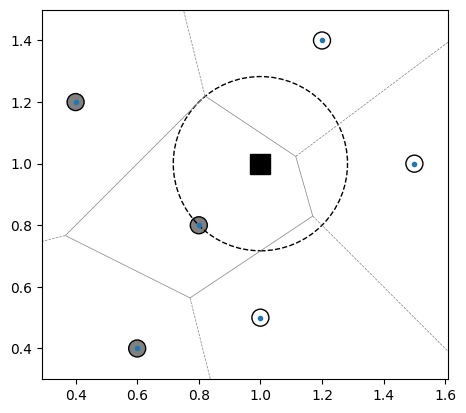

In [1]:
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy.spatial import Voronoi, voronoi_plot_2d

def knn(x_train, y_train, x_test, k):
    distances = []
    x1 = x_test # Elemento a ser classificado
    for x2 in x_train:
        dist = distance.euclidean(x1, x2)
        distances.append(dist)
    indices = []
    cl = []
    for i in range(0,k):
        ind = np.argmin(distances)
        d = distances[ind]
        distances[ind] = np.max(distances)
        indices.append(ind)
        cl.append(y_train[ind])
    print("Classes:", cl)
    classification = statistics.mode(cl)
    return classification, d

# Parâmetro
k=1

x_train = np.array(
    [
        [1.0, 0.5],
        [0.8, 0.8],
        [1.2, 1.4],
        [0.6, 0.4],
        [0.4, 1.2],
        [1.5, 1.0]       
    ])

y_train = np.array(
    [
        'white', 
        'gray', 
        'white', 
        'gray', 
        'gray', 
        'white'
    ], dtype = 'str')

x_test = np.array([1,1])

cl, d = knn(x_train, y_train, x_test, k)
print("Classification: ", cl)

# Pontos coloridos no gráfico
fig, ax = plt.subplots()
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=150, marker='o', edgecolor='black')
ax.plot(x_test[0], x_test[1], marker='s', markersize=15, color='black')
ax.set_xlim(0.2, 1.6)
ax.set_ylim(0, 1.6)

# Desenhar o círculo de raio de detecção
circle = plt.Circle((1, 1), d, fill=False, linestyle='--')
ax.add_artist(circle)

ax.set_aspect('equal', adjustable='box')

# Desenha a região de decisão com telhas de Voronoi
vor = Voronoi(x_train)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='grey', line_width=0.5)

plt.savefig('knn.eps')

plt.show()

Classes: ['gray', 'white', 'white']
Classification:  white


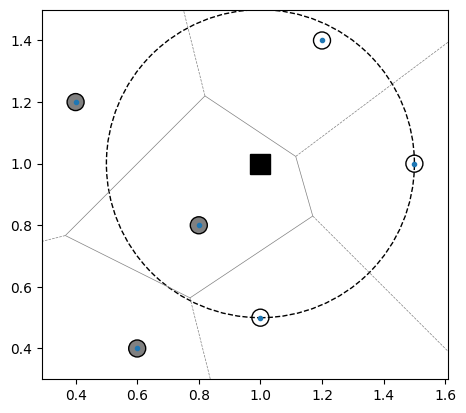

In [2]:
k=3

cl, d = knn(x_train, y_train, x_test, k)
print("Classification: ", cl)

# Pontos coloridos no gráfico
fig, ax = plt.subplots()
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=150, marker='o', edgecolor='black')
ax.plot(x_test[0], x_test[1], marker='s', markersize=15, color='black')
ax.set_xlim(0.2, 1.6)
ax.set_ylim(0, 1.6)

# Desenhar o círculo de raio de detecção
circle = plt.Circle((1, 1), d, fill=False, linestyle='--')
ax.add_artist(circle)

ax.set_aspect('equal', adjustable='box')

# Desenha a região de decisão com telhas de Voronoi
vor = Voronoi(x_train)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='grey', line_width=0.5)

plt.savefig('knn.eps')

plt.show()

Number of nodes: 77
Number of edges: 254
Xnet: (1, 6)
Classe: BA
Classe: BA
Classe: BA


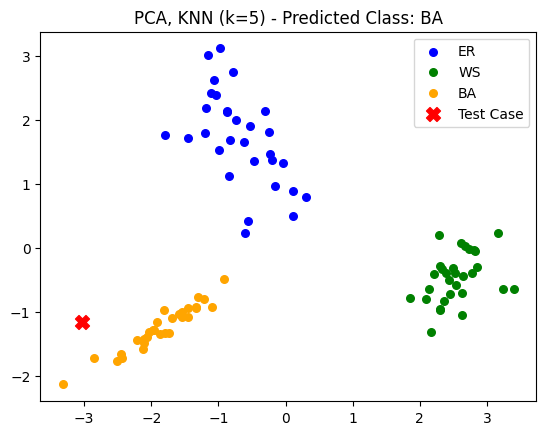

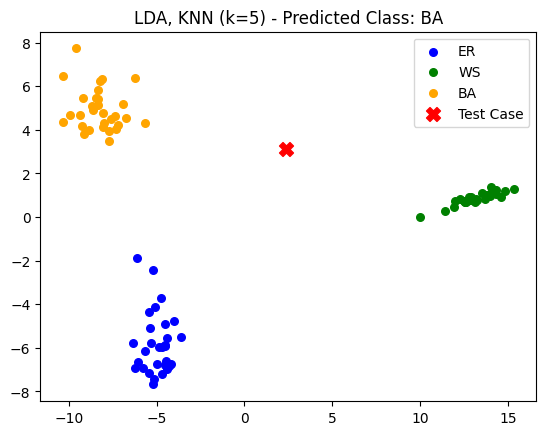

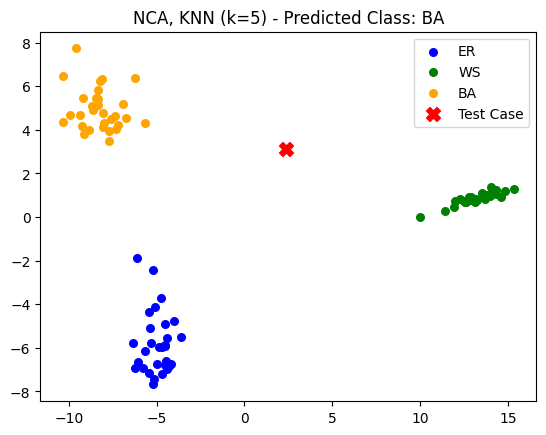

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


G= nx.read_edgelist("data/lesmis.txt", nodetype=int, data=(('weight',float),))
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1, k2, variance, av_cl, l, r

k1,k2,variance,av_cl,l,r = measures(G)
X_net = [k1,k2,variance,av_cl,l,r]
cl = ['ER','WS','BA']

#ER networks
X = []
y = []
n_nets = 30
av_degree = k1
p = av_degree/(N-1)
for i in range(0,n_nets):
    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GER)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(0)

#WS networks
k = int(av_degree)
p = 0.1 #probability of rewiring
for i in range(0,n_nets):
    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GWS)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(1)

# BA networks
m = int(av_degree/2)
for i in range(0,n_nets):
    GBA = nx.barabasi_albert_graph(N, m)    
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GBA)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(2)
    
X = np.array(X)
y = np.array(y)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net)) 
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)


# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=0),
)

dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

# Define colors for each class and for the test case
colors = ['blue', 'green', 'orange', 'red']

k = 5
knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')

# Plot each method's projection
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # Fit the method's model
    model.fit(X, y)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Embed the test case in 2 dimensions using the fitted model
    X_test_embedded = model.transform(X_net.reshape(1, -1))

    # Make predictions using KNN
    knn.fit(X_embedded, y)
    y_pred = knn.predict(X_test_embedded)
    
    print('Classe:', cl[int(np.mean(y_pred))])

    # Plot the projected points with different colors for each class and the test case
    for j in range(len(cl)):
        plt.scatter(
            X_embedded[y == j, 0],
            X_embedded[y == j, 1],
            c=colors[j],
            s=30,
            label=cl[j],
        )
    plt.scatter(
        X_test_embedded[:, 0],
        X_test_embedded[:, 1],
        c=colors[-1],
        s=100,
        marker="X",
        label="Test Case",
    )

    # Show the evaluation score in the plot title
    plt.title(
        f"{name}, KNN (k={k}) - Predicted Class: {cl[int(np.mean(y_pred))]}"
    )
    plt.legend()
plt.show()

Number of nodes: 180
Number of edges: 1202
Xnet: (1, 6)
Classe: WS
Classe: WS
Classe: WS
Classe: WS


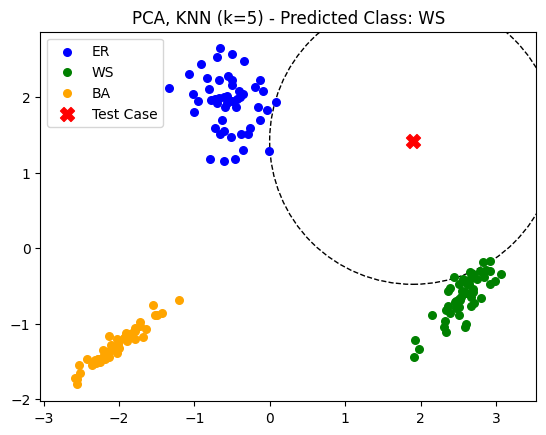

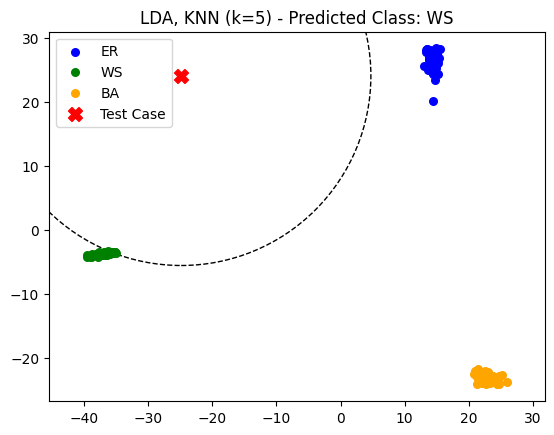

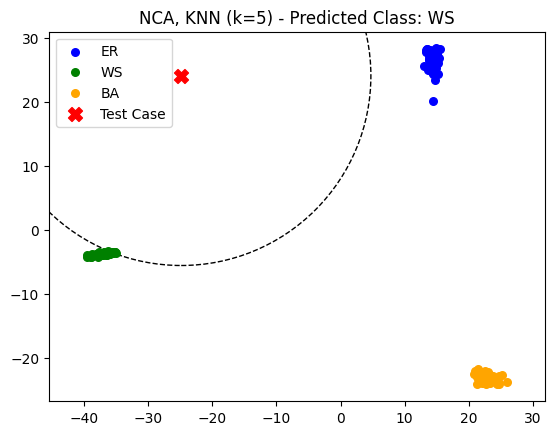

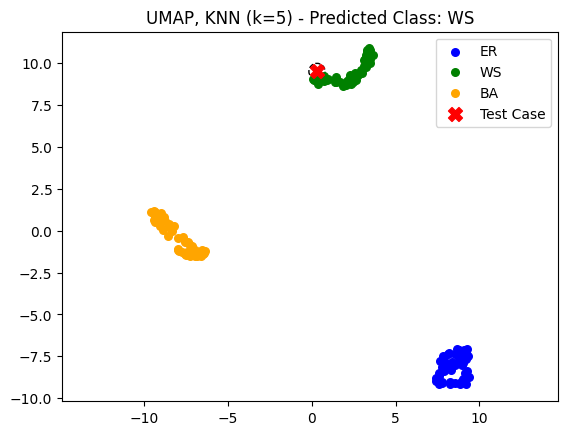

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import umap
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


G= nx.read_edgelist("data/graph_connectome_0.txt", nodetype=int, data=(('weight',float),))
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1, k2, variance, av_cl, l, r

k1,k2,variance,av_cl,l,r = measures(G)
X_net = [k1,k2,variance,av_cl,l,r]
cl = ['ER','WS','BA']

#ER networks
X = []
y = []
n_nets = 50
av_degree = k1
p = av_degree/(N-1)
for i in range(0,n_nets):
    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GER)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(0)

#WS networks
k = int(av_degree)
p = 0.1 #probability of rewiring
for i in range(0,n_nets):
    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GWS)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(1)

# BA networks
m = int(av_degree/2)
for i in range(0,n_nets):
    GBA = nx.barabasi_albert_graph(N, m)    
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GBA)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(2)
    
X = np.array(X)
y = np.array(y)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net)) 
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)


# Reduce dimension to 2 with PCA Principal Component Analysis
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))

# Reduce dimension to 2 with Linear Discriminant Analysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with Neighborhood Component Analysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=0),
)

uma = umap.UMAP()

dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca), ("UMAP", uma)]

# Define colors for each class and for the test case
colors = ['blue', 'green', 'orange', 'red']

k = 5
knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')

# Plot each method's projection
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # Fit the method's model
    model.fit(X, y)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Embed the test case in 2 dimensions using the fitted model
    X_test_embedded = model.transform(X_net.reshape(1, -1))

    # Make predictions using KNN
    knn.fit(X_embedded, y)
        
    # Find the k nearest neighbors to the center point
    _, indices = knn.kneighbors(X_test_embedded, n_neighbors=k)
    neighbors = X_embedded[indices][0]

    # Calculate the radius of the circle
    radius = np.max(np.linalg.norm(neighbors - X_test_embedded, axis=1))

    # Draw a circle around the center point with the calculated radius
    circle = plt.Circle([X_test_embedded[:,0], X_test_embedded[:,1]], radius, color='black', fill=False, linestyle='dashed')
    plt.gca().add_artist(circle)
    
    y_pred = knn.predict(X_test_embedded)
    
    print('Classe:', cl[int(np.mean(y_pred))])

    # Plot the projected points with different colors for each class and the test case
    for j in range(len(cl)):
        plt.scatter(
            X_embedded[y == j, 0],
            X_embedded[y == j, 1],
            c=colors[j],
            s=30,
            label=cl[j],
        )
    plt.scatter(
        X_test_embedded[:, 0],
        X_test_embedded[:, 1],
        c=colors[-1],
        s=100,
        marker="X",
        label="Test Case",
    )
    plt.title(
        f"{name}, KNN (k={k}) - Predicted Class: {cl[int(np.mean(y_pred))]}"
    )
    plt.legend()
    plt.axis('equal')
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def compute_measures(G):
    """Computa medidas de centralidade e estrutura de um grafo."""
    vk = list(dict(G.degree()).values())
    N = len(G)
    k1 = sum(vk) / N
    k2 = sum(np.power(vk, 2)) / N
    variance = k2 - np.power(k1, 2)
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r = nx.degree_assortativity_coefficient(G)
    return k1, k2, variance, av_cl, l, r

def generate_ER_networks(n, N, p):
    """Gera n redes aleatórias do tipo Erdős-Rényi com N nós e probabilidade p."""
    X = []
    y = []
    for i in range(n):
        GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        x = compute_measures(GER)
        X.append(x)
        y.append(2)
    return X, y


def generate_WS_networks(n, N, k, p):
    """Gera n redes aleatórias do tipo Watts-Strogatz com N nós, grau médio k e probabilidade p."""
    X = []
    y = []
    for i in range(n):
        GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
        Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
        GWS = GWS.subgraph(Gcc[0])
        GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        x = compute_measures(GWS)
        X.append(x)
        y.append(1)
    return X, y


def generate_BA_networks(n, N, m):
    """Gera n redes aleatórias do tipo Barabási-Albert com N nós e grau médio m."""
    X = []
    y = []
    for i in range(n):
        GBA = nx.barabasi_albert_graph(N, m)
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        x = compute_measures(GBA)
        X.append(x)
        y.append(0)
    return X, y

G= nx.read_edgelist("data/lesmis.txt", nodetype=int, data=(('weight',float),))
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

k1, k2, variance, av_cl, l, r = compute_measures(G)
X_net = [k1,k2,variance,av_cl,l,r]
cl = ['ER','WS','BA']

    
X = np.array(X)
y = np.array(y)

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net)) 
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
knn.fit(X,y)

y_pred = knn.predict(X_net) 
print('Classe:', cl[int(y_pred)])

Number of nodes: 77
Number of edges: 254
Xnet: (1, 6)
Classe: BA
